In [1]:
import numpy as np
import torch
from tqdm.notebook import tqdm

In [2]:
# The data generation and plotting code was inspired by the repo https://github.com/mattjj/pyslds released under the MIT License.
# Link: https://github.com/mattjj/pyslds/blob/master/examples/slds_example_figure.py

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style="white")

color_names = ["red",
               "windows blue",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "light cyan",
               "steel blue",
               "pastel purple",
               "mint",
               "salmon"]

colors = sns.xkcd_palette(color_names)

In [3]:

def show_duration_dists(fig_size,
                        rho,
                        fig_title=None):
    K, d_max = rho.shape
    fig, axn = plt.subplots(nrows=K, figsize=fig_size)
    if fig_title:
        plt.title(fig_title)
    for k in range(K):
        axn[k].bar(np.arange(d_max), rho[k])
        # axn[k].set_ylim((0., 1.))
        axn[k].set_ylabel(f'State {k}')
        axn[k].set_xticks(np.arange(d_max))
    plt.show()

In [4]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
x_dim = 2
obs_dim = 1
K = 3
d_max = 20

In [6]:
Tr = [[0.1, 0.2, 0.7],
      [0.3, 0.5, 0.2],
      [0.3,  0.3, 0.4]]

In [7]:
mu_init = np.zeros((K, x_dim))
mu_init[:, 0] = 2.0
sigma_init = 0.1 * np.ones(x_dim)
x_init = torch.distributions.normal.Normal(
    torch.from_numpy(mu_init),
    torch.from_numpy(sigma_init))
x_init = torch.distributions.independent.Independent(x_init, 1)
x_init.sample()

tensor([[ 2.0337,  0.0129],
        [ 2.0234,  0.0230],
        [ 1.8877, -0.0186]], dtype=torch.float64)

In [8]:
def random_rotation(n, theta):
    rot = 0.99 * np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta), np.cos(theta)]])
    out = np.zeros((n, n))
    out[:2, :2] = rot
    q = np.linalg.qr(np.random.randn(n, n))[0]
    return q.dot(out).dot(q.T)

def x_transition(As, bs, xtm1, zt):
    A, b = As[zt], bs[zt]
    h = (A @ xtm1.t()).t() + b
    dist = torch.distributions.normal.Normal(h, 0.1)
    dist = torch.distributions.independent.Independent(dist, 1)
    return dist

In [9]:
ths = np.linspace(0, np.pi/4., K)
As = [random_rotation(x_dim, ths[k]) for k in range(K)]
bs = [np.zeros((1, x_dim))] + [.25 * np.random.randn(1, x_dim) for k in range(K-1)]
As = list(map(torch.from_numpy, As))
bs = list(map(torch.from_numpy, bs))

In [10]:
def y_emission(C, d, xt):
    h = (C @ xt.t()).t() + d
    dist = torch.distributions.normal.Normal(h, 0.2)
    dist = torch.distributions.independent.Independent(dist, 1)
    return dist

In [11]:
Cs = [torch.from_numpy(np.random.randn(obs_dim, x_dim)) for _ in range(K)]
ds = [torch.from_numpy(np.random.randint(3, size=(1, obs_dim))) for _ in range(K)]

In [12]:
def make_U(D):
    U = 1-D/np.cumsum(D[:,::-1], 1)[:,::-1]
    return U

rho = np.zeros((K, d_max))

rho[0, 5] = 2
rho[0, 10] = 5
rho[0, 15] = 7
rho[0, 19] = 3
rho[1, 7] = 5
rho[1, 16] = 8
rho[1, 18] = 6
rho[1, 19] = 1
rho[2, 12] = 3
rho[2, 15] = 7
rho[2, 17] = 5
rho[2, 19] = 2

rho = rho / np.sum(rho, -1, keepdims=True)
U = make_U(rho)

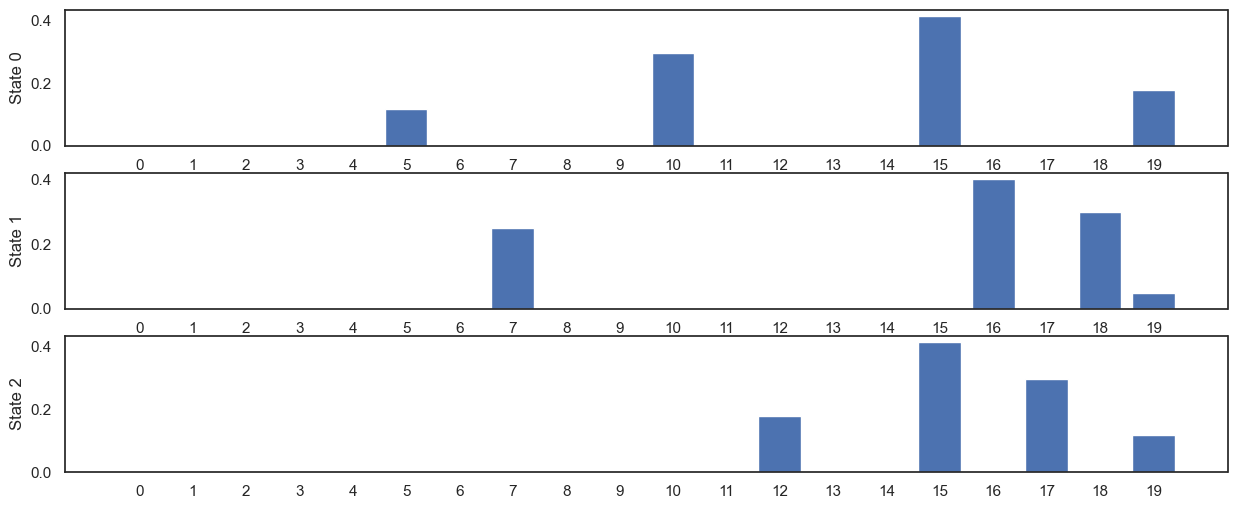

In [14]:
show_duration_dists((15, 2 * K), rho)

In [20]:
def generate_timeseries(T=100):
    cs, zs, xs, ys = [], [], [], []
    ct = 0
    zt = np.random.randint(K)
    xt = x_init.sample()[zt].view(1, x_dim)
    for i in range(T):
        yt = y_emission(Cs[zt], ds[zt], xt).sample()
        cs += [ct]
        zs += [zt]
        xs += [xt.data.numpy()]
        ys += [yt.data.numpy()]
        p_inc_count = U[zt, ct]
        if np.random.rand() < p_inc_count:
            ct += 1
        else:
            ct = 0
        if ct > 0:
            zt = zt
        else:
            zt = np.random.choice([0, 1, 2], p=Tr[zt])
        xt = x_transition(As, bs, xt, zt).sample()
        
    return np.stack(cs), np.stack(zs), np.concatenate(xs, 0), np.concatenate(ys, 0)

In [17]:
def draw_slds_figure(z, x, y, filename=None):
    fig = plt.figure(figsize=(10, 2.7))
    gs = gridspec.GridSpec(5, 1)
    ax = fig.add_subplot(gs[2:, 0])
    ylim = 1.1 * abs(y).max()
    ymax = ylim * (2*obs_dim + 1)
    ymin = -ylim

    # Plot the discrete state in the background
    cps = np.where(np.diff(z) != 0)[0] + 1
    left_cps = np.concatenate(([0], cps))
    right_cps = np.concatenate((cps, [T]))
    for l,r in zip(left_cps, right_cps):
        ax.add_patch(
            Rectangle([l, ymin], r-l, ymax-ymin,
                      color=colors[z[l]], ec="none", alpha=0.5))

        ax.plot([r, r], [ymin, ymax], '-', color="gray", lw=1)

    # Plot the observations
    for i in range(obs_dim):
        ax.plot(np.arange(T), ylim * (2*i+1) + y[:,i], '-k', lw=1)

    ax.set_xlim(0, T)
    ax.set_xlabel("time")

    ax.set_ylim(ymin, ymax)
    ax.set_yticks([])
    ax.set_yticks(ylim * (2*np.arange(obs_dim)+1))

    def yticklabel(i):
        return "$n=%d$" % (obs_dim-i) if (i >= obs_dim-2) else \
            "$n=N$" if i == 0 else "."

    ax.set_yticklabels(map(yticklabel, np.arange(obs_dim)))
    ax.yaxis.labelpad = 0
    ax.set_ylabel("${\\mathbf{y}_t}$", rotation=0, verticalalignment='center')

    ## Plot the continuous latent state above that above
    ax = fig.add_subplot(gs[1, 0])
    xlim = 1.1 * abs(x).max()
    for l, r in zip(left_cps, right_cps):
        ax.add_patch(
            Rectangle([l, -xlim], r - l, 2*xlim,
                      color=colors[z[l]], ec="none", alpha=0.5))

        ax.plot([r, r], [-xlim, xlim], '-', color="gray", lw=1)

    linestyles = ["-", ":"]
    for i in range(x_dim):
        ax.plot(np.arange(T), x[:, i],
                'k', ls=linestyles[i%len(linestyles)], lw=1)

    ax.set_xlim(0, T)
    ax.set_ylim(-xlim, xlim)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.yaxis.labelpad = 34
    ax.set_ylabel("${\\mathbf{x}_t}$", rotation=0, verticalalignment='center')

    ## Now plot the latent state above that above
    ax = fig.add_subplot(gs[0, 0])
    for l, r in zip(left_cps, right_cps):
        ax.add_patch(
            Rectangle([l, 0], r - l, 10,
                      color=colors[z[l]], ec="none", alpha=0.5))

        ax.plot([r, r], [0, 10], '-', color="gray", lw=1)
#         ax.text(l + (r - l) / 2. - 10., 3,
#                 # "u" if z[l] == 0 else "d",
#                 # string.ascii_lowercase[z[l]],
#                 z[l]+1,
#                 fontdict={"size": 9})
    ax.set_xlim(0, T)
    ax.set_ylim(0, 10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.yaxis.labelpad = 34
    ax.set_ylabel("${\\mathbf{z}_t}$", rotation=0, verticalalignment='center')

    if filename is not None:
        fig.savefig(filename)

    plt.show()

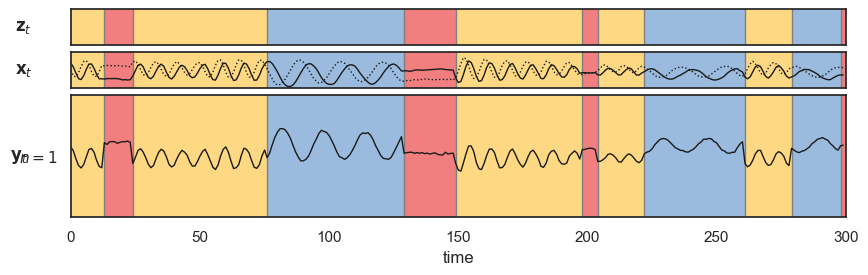

In [18]:
T = 300
cs, zs, xs, ys = generate_timeseries(T)
draw_slds_figure(zs, xs, ys)

In [21]:
data_y = []
data_z = []
for i in tqdm(range(10000)):
    cs, zs, xs, ys = generate_timeseries(T)
    data_y.append(ys)
    data_z.append(zs)
data_y = np.asarray(data_y)
data_z = np.asarray(data_z)
data_y.shape, data_z.shape

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
rho

In [ ]:
np.savez('3modesystem.npz', y=data_y, z=data_z)

In [23]:
tdata_y = []
tdata_z = []
for i in tqdm(range(500)):
    cs, zs, xs, ys = generate_timeseries(T)
    tdata_y.append(ys)
    tdata_z.append(zs)
tdata_y = np.asarray(tdata_y)
tdata_z = np.asarray(tdata_z)
tdata_y.shape, tdata_z.shape

  0%|          | 0/500 [00:00<?, ?it/s]

((500, 300, 1), (500, 300))

In [24]:
np.savez('3modesystem_test.npz', y=tdata_y, z=tdata_z)

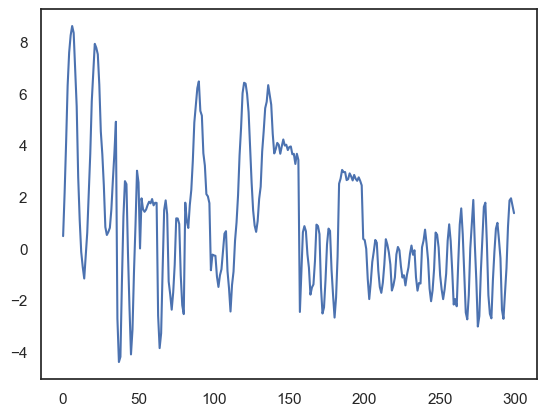

In [28]:
plt.plot(tdata_y[0])


In [25]:
import fractions
np.set_printoptions(formatter={'all':lambda x: str(fractions.Fraction(x).limit_denominator())})
print(rho)

[[0 0 0 0 0 2/17 0 0 0 0 5/17 0 0 0 0 7/17 0 0 0 3/17]
 [0 0 0 0 0 0 0 1/4 0 0 0 0 0 0 0 0 2/5 0 3/10 1/20]
 [0 0 0 0 0 0 0 0 0 0 0 0 3/17 0 0 7/17 0 5/17 0 2/17]]
